# Training the model

### Import Necessary Libraries

In [ ]:
 !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cudf
import cupy
import cuml
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from cuml.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%load_ext cudf.pandas
pd.set_option('display.max_rows', None)  # No limit on the number of rows displayed
pd.set_option('display.max_columns', None)

In [6]:
df_north = pd.read_csv('/content/drive/MyDrive/PeMS Data/df_north.csv')

Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.


### Define Features and Target

In [7]:
FEATURES = ['Abs_PM', 'Month', 'Day', 'Latitude', 'Longitude','Hour', 'minutesOfDay', 'main.temp',
            'main.feels_like', 'main.pressure', 'main.humidity', 'wind.speed', 'wind.deg',
          'clouds.all', 'rain.1h', 'DayOfWeek_Friday', 'DayOfWeek_Monday',
         'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
        'DayOfWeek_Wednesday', 'City_17610.0', 'City_17918.0', 'City_47486.0', 'City_65028.0',
        'City_67000.0', 'City_68000.0', 'City_69084.0', 'City_73262.0', 'City_86440.0',
        'County_75.0', 'County_81.0', 'County_85.0', 'weather.desc_broken clouds',
        'weather.desc_clear sky', 'weather.desc_few clouds', 'weather.desc_fog',
        'weather.desc_haze', 'weather.desc_heavy intensity rain',
        'weather.desc_light intensity drizzle', 'weather.desc_light rain', 'weather.desc_mist',
        'weather.desc_moderate rain', 'weather.desc_overcast clouds',
        'weather.desc_scattered clouds', 'weather.desc_smoke']

TARGET = 'Avg Speed'

X = df_north[FEATURES]
y = df_north[TARGET]

### Convert to Cudf for GPU Utilization

In [8]:
X = cudf.DataFrame.from_pandas(X.reset_index(drop=True))
y = cudf.Series.from_pandas(y.reset_index(drop=True))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train = X_train.sort_index().reset_index(drop=True)
y_train = y_train.sort_index().reset_index(drop=True)
X_test = X_test.sort_index().reset_index(drop=True)
y_test = y_test.sort_index().reset_index(drop=True)

### Define Function for Error Metrics

In [10]:
def evaluate_model(predictions, actual, model_name):
    rmse = np.sqrt((predictions - actual).pow(2).mean())
    mae = (predictions - actual).abs().mean()
    explained_variance = 1 - ((predictions - actual).pow(2).mean() / (actual - actual.mean()).pow(2).mean())
    mean_error = (predictions - actual).mean()
    r2 = 1 - ((y_pred - y_test).pow(2).mean() / (y_test - y_test.mean()).pow(2).mean())

    return cudf.Series({'RMSE': rmse, 'MAE': mae, 'Explained Variance': explained_variance, 'Mean Error': mean_error, 'R2': r2}, name=model_name)

### Define Asymetric Error Function (under-predictions are more severe than over-predictions)


In [11]:
def asymmetric_squared_error(preds, dtrain):
    labels = dtrain.get_label()
    asymmetry_factor = 50
    residual = (preds - labels)
    grad = np.where(residual > 0, asymmetry_factor * residual, residual)
    hess = np.where(residual > 0, asymmetry_factor, 1.0)

    return grad, hess

### Random Search for Hyperparameter Tuning

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

xgb_params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse',
    'subsample': 0.7,
}

params = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [800, 1000],
    'colsample_bytree': [0.3, 0.7, 1]
}

xgb_model = xgb.XGBRegressor(**xgb_params)
kf = KFold(n_splits=4, shuffle=True, random_state=1001)

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=params,
    n_iter=10,
    cv=kf,
    random_state=1001
)

X_train_cpu = X_train.to_pandas() if isinstance(X_train, cudf.DataFrame) else X_train
y_train_cpu = y_train.to_pandas() if isinstance(y_train, cudf.Series) else y_train

random_search.fit(X_train_cpu, y_train_cpu)

# Print the best parameters and lowest RMSE
print("Best parameters:", random_search.best_params_)
print("Lowest RMSE:", (-random_search.best_score_) ** 0.5)

### Train the model

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 10,
    'learning_rate': 0.2,
    'subsample': 0.7,
    'colsample_bytree': 1,
    'reg_lambda': 2.5,
    'scale_pos_weight': 10,
    'tree_method': 'hist',
    'device': 'cuda'
}

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Use the custom objective in model training
model = xgb.train(params,
                  dtrain=dtrain,
                  num_boost_round=1000,
                  early_stopping_rounds=50,
                  evals=[(dval, 'validation')],
                  verbose_eval=200,
                  obj=asymmetric_squared_error)

y_pred = model.predict(dtest)
y_pred = cudf.Series(y_pred)

[0]	validation-rmse:50.36366
[200]	validation-rmse:3.91109
[400]	validation-rmse:3.30965
[600]	validation-rmse:2.99638
[800]	validation-rmse:2.80066
[999]	validation-rmse:2.63888
RMSE                  2.622387
MAE                   1.542456
Explained Variance    0.736032
Mean Error           -1.346129
R2                    0.736032
Name: XGBoost Model, dtype: float64


### Error Metrics

In [14]:
evaluation_results = evaluate_model(y_pred, y_test, 'XGBoost Model')
print(evaluation_results)

RMSE                  2.622387
MAE                   1.542456
Explained Variance    0.736032
Mean Error           -1.346129
R2                    0.736032
Name: XGBoost Model, dtype: float64


In [15]:
## CuDF to Numpy
y_test_np = y_test.to_numpy()
y_pred_np = y_pred.to_numpy()

In [16]:
total_predictions = len(y_pred_np)
greater_count = np.sum(y_pred_np > y_test_np)
greater_percentage = (greater_count / total_predictions) * 100
less_count = np.sum(y_pred_np < y_test_np)
less_percentage = (less_count / total_predictions) * 100

print(f"Number of predictions greater than actuals: {greater_count} ({greater_percentage:.2f}%)")
print(f"Number of predictions less than actuals: {less_count} ({less_percentage:.2f}%)")


Number of predictions greater than actuals: 170700 (12.90%)
Number of predictions less than actuals: 1153015 (87.10%)


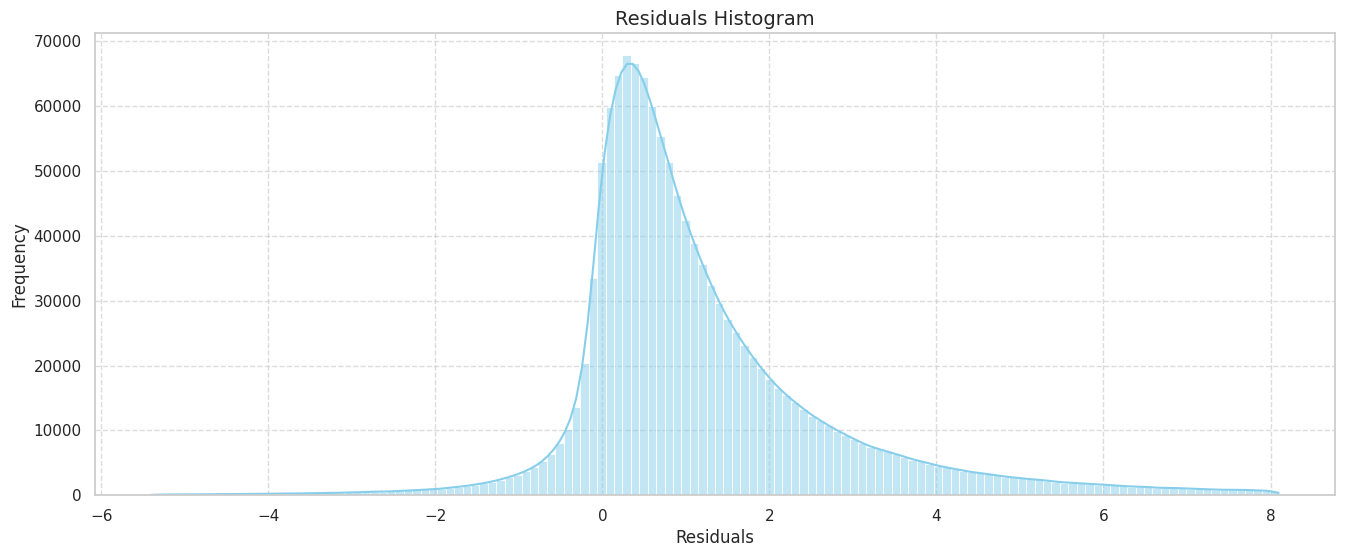

In [19]:
residuals = y_test_np - y_pred_np

# We're taking only residuals within 3 standard deviations for the histogram
std_dev = np.std(residuals)
residuals_filtered = residuals[(residuals > np.mean(residuals) - 3 * std_dev) & (residuals < np.mean(residuals) + 3 * std_dev)]

bin_width = 0.1
bins = int((residuals_filtered.max() - residuals_filtered.min()) / bin_width)

# Residuals Histogram
plt.figure(figsize=(16, 6))
sns.histplot(residuals_filtered, bins=bins, kde=True, color='skyblue', edgecolor='w')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Residuals Histogram", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  # Use a logarithmic scale on the y-axis
plt.show()

### What features had biggest impact on model?

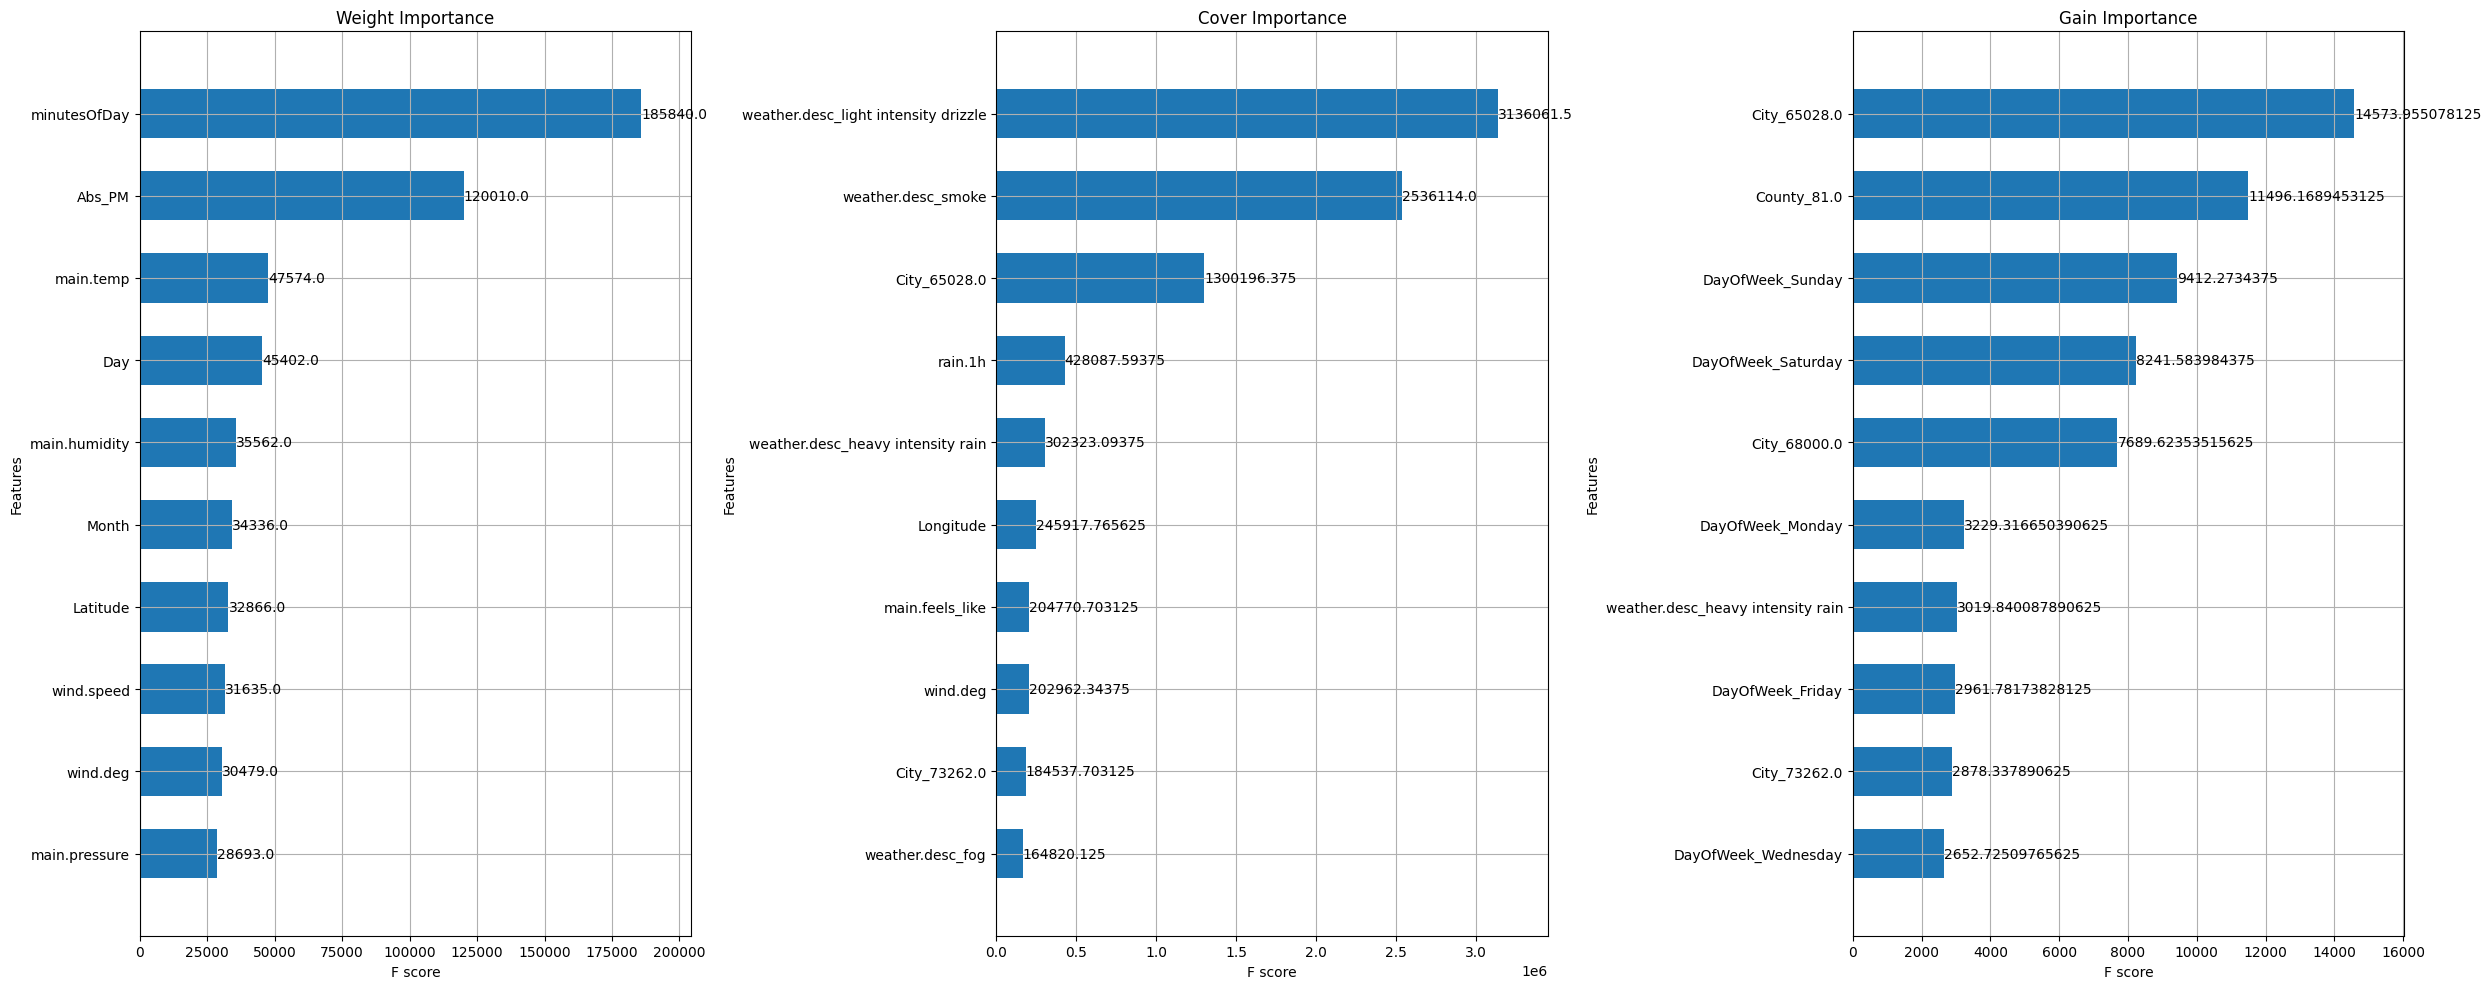

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

# Plot 'weight' importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.6, ax=axs[0], title='Weight Importance')

# Plot 'cover' importance
xgb.plot_importance(model, importance_type='cover', max_num_features=10, height=0.6, ax=axs[1], title='Cover Importance')

# Plot 'gain' importance
xgb.plot_importance(model, importance_type='gain', max_num_features=10, height=0.6, ax=axs[2], title='Gain Importance')

# Adjust layout
plt.tight_layout()
plt.show()